In [1]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
import matplotlib.pyplot as plt

In [3]:
import scanpy.external as sce

In [4]:
import torch
import pickle

In [5]:
import anndata

In [6]:
import h5py

In [7]:
import os

#### Load data

In [10]:
adata = sc.read('lung_tumor.h5ad')

#### QC

In [31]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # annotate ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [33]:
adata = adata[adata.obs.total_counts > 300, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 40000, :]

#### Train model

In [49]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", labels_key='med_cell_type_chan')

In [50]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [51]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 11/11: 100%|██████████| 11/11 [13:15<00:00, 72.33s/it, loss=3.47e+03, v_num=1]


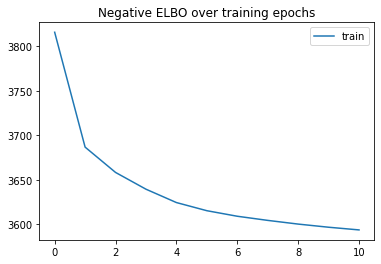

In [21]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [52]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
)

In [53]:
lvae.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [56:37<00:00, 135.92s/it, loss=3.58e+03, v_num=1]


In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)

In [ ]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [23]:
lvae.save('lung_tumor_all_cells_scanvi', overwrite=True)

In [14]:
lvae = scvi.model.SCANVI.load('lung_tumor_all_cells_scanvi', adata=adata)

INFO     File ../../lagringshotellet/Users/Herman/data/zenodo/lung_tumor_all_cells_scanvi/model.pt already         
         downloaded                                                                                                


INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [54]:
adata.obs["C_scANVI"] = lvae.predict(adata)

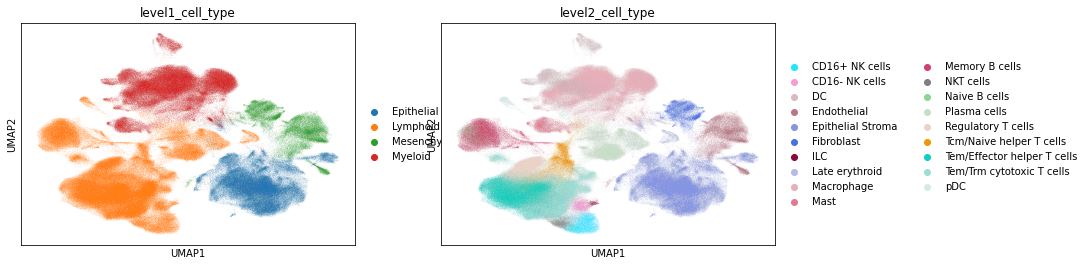

In [15]:
sc.pl.umap(adata, color=['level1_cell_type', 'level2_cell_type'])#, save='lung_tumor_all_cells_level1_level2.pdf')

In [56]:
de_df = lvae.differential_expression(
    groupby="level2_cell_type", delta=0.5, batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 15/15 [11:52<00:00, 47.48s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
TCL1A,0.988071,0.011929,4.416760,0.000107,9.175801e-06,0.0,0.5,6.997288,7.299613,2.803609,...,1.167192,0.033779,0.514793,0.007809,5.673952,0.090325,True,B cells vs Rest,B cells,Rest
FCER2,0.979638,0.020362,3.873513,0.000071,3.865503e-06,0.0,0.5,5.922980,6.280273,2.335922,...,0.741671,0.014309,0.430938,0.009978,3.305717,0.044203,True,B cells vs Rest,B cells,Rest
KHDRBS2,0.971205,0.028795,3.518345,0.000007,6.172043e-07,0.0,0.5,4.596454,4.823655,2.094243,...,0.027388,0.002001,0.026036,0.001927,0.130441,0.006432,True,B cells vs Rest,B cells,Rest
FCRL1,0.971000,0.029000,3.511016,0.000051,3.348802e-06,0.0,0.5,5.872606,6.253956,2.149765,...,0.294171,0.011303,0.230262,0.010019,1.470050,0.042130,True,B cells vs Rest,B cells,Rest
AFF3,0.970177,0.029823,3.482194,0.000080,6.419942e-06,0.0,0.5,5.222831,5.485024,2.205760,...,0.318348,0.023598,0.249366,0.019163,1.544695,0.080067,True,B cells vs Rest,B cells,Rest


In [ ]:
for g in np.unique(de_df['group1']):
    sig_dict[g] = list(de_df[(de_df['group1'] == g) & 
                             (de_df['proba_de'] > 0.8) & 
                             #(de_df['non_zeros_proportion2'] < 0.1) &
                             (de_df['non_zeros_proportion1'] > 0.3)].sort_values('lfc_mean', ascending=False).index[:3])

In [ ]:
sig_dict

{'B cells': ['TCL1A', 'VPREB3', 'MS4A1'],
 'CD56bright NK cells': ['KLRC1', 'TRDC', 'XCL2'],
 'CD56dim NK cells': ['FGFBP2', 'KLRF1', 'TRDC'],
 'Dendritic cells': ['FCN1', 'VCAN', 'EREG'],
 'ILCs': ['XCL1', 'SPINK2', 'TMIGD2'],
 'Late erythroid': ['HBB', 'HBA1', 'HBA2'],
 'Macrophages': ['C1QC', 'MRC1', 'C1QB'],
 'Mast cells': ['TPSAB1', 'CPA3', 'TPSB2'],
 'Memory B cells': ['MS4A1', 'VPREB3', 'CD79A'],
 'NKT cells': ['FGFBP2', 'TRGC2', 'KLRG1'],
 'Plasma cells': ['IGHG2', 'IGHA2', 'MZB1'],
 'Regulatory T cells': ['CTLA4', 'TIGIT', 'TNFRSF4'],
 'Tcm/Naive helper T cells': [],
 'Tem/Effector helper T cells': [],
 'Tem/Trm cytotoxic T cells': ['CD8B', 'CD8A', 'GZMH']}

In [ ]:
adata_immune = adata[adata.obs['level1_cell_type'].isin(['Lymphoid', 'Myeloid'])].copy()

In [ ]:
adata_immune_norm = adata_immune.copy()

In [101]:
sc.pp.normalize_total(adata_immune_norm, target_sum=1e4)

In [103]:
sc.pp.log1p(adata_immune_norm)

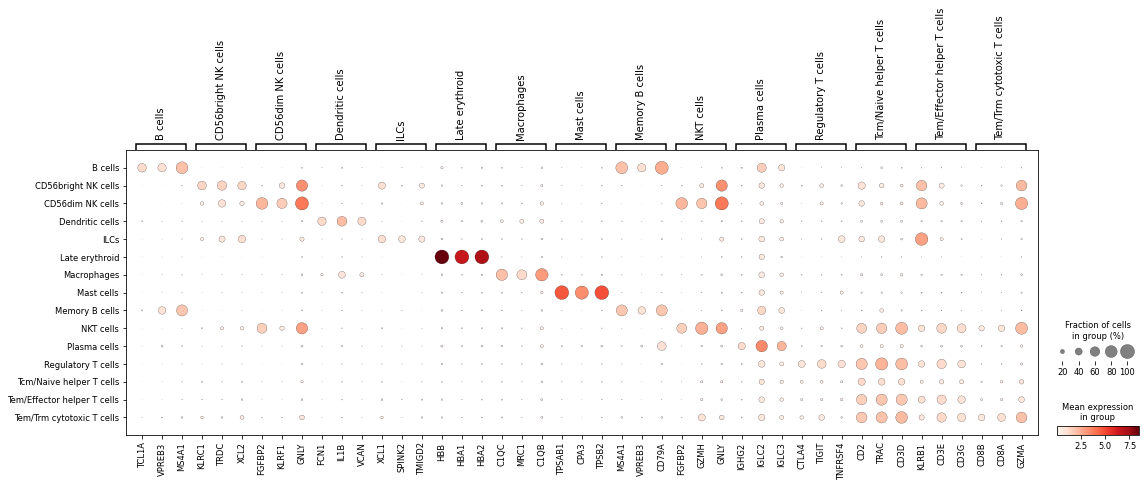

In [132]:
sc.pl.dotplot(adata_immune_norm, sig_dict, groupby='level2_cell_type', save='dotplot_immune_cell_types_signatures.pdf')

#### Sankey

In [16]:
level1_level2_df = sc.get.obs_df(adata,keys=['level1_cell_type', 'level2_cell_type'])
level1_level2_df = pd.crosstab(level1_level2_df['level1_cell_type'], level1_level2_df['level2_cell_type']).T

In [17]:
level2_color_dict = dict(np.array([adata.obs['level2_cell_type'].cat.categories, adata.uns['level2_cell_type_colors']]).T)

In [18]:
level1_color_dict = dict(np.array([adata.obs['level1_cell_type'].cat.categories, adata.uns['level1_cell_type_colors']]).T)

In [19]:
from utils.sankey_diagram import sankey_diagram

In [20]:
order_cell_types = ['Epithelial', 'Mesenchymal', 'Myeloid', 'Lymphoid']

In [21]:
level1_level2_df = level1_level2_df[order_cell_types]

In [22]:
a_sort = list(np.flip(order_cell_types))

In [26]:
sankey_diagram(adata.obs[['level1_cell_type', 'level2_cell_type']].to_numpy(), level1_color_dict, level2_color_dict, a_sort=a_sort, b_sort=b_sort, figsize=(8,12), save_path=os.path.join(figures_dir, 'sankey_level1_level2.pdf'))

/itf-fi-ml/home/hermankn/notebooks/utils/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)


/itf-fi-ml/home/hermankn/notebooks/utils/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


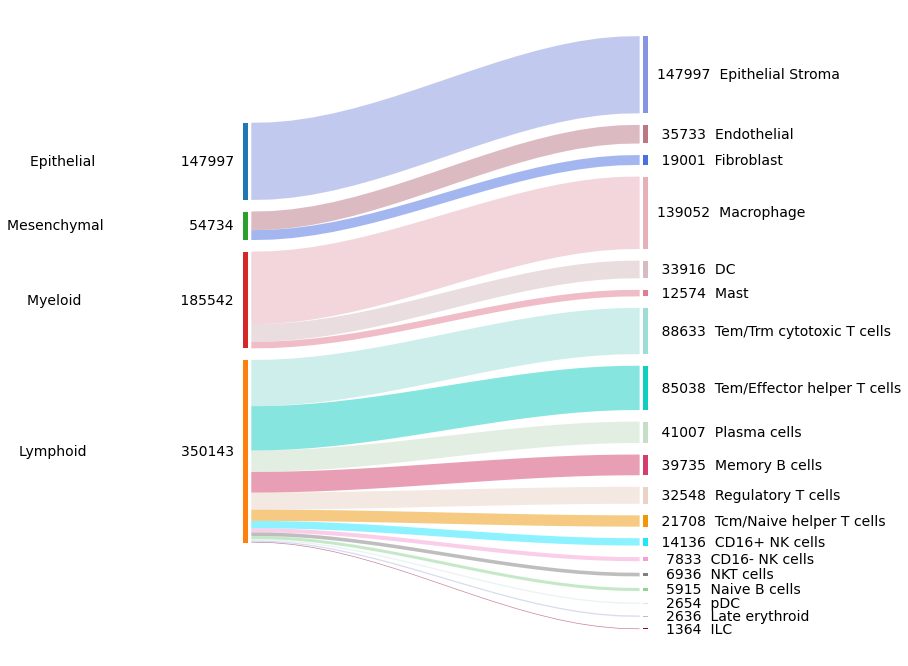

In [24]:
sankey_diagram(adata.obs[['level1_cell_type', 'level2_cell_type']].to_numpy(), level1_color_dict, level2_color_dict, a_sort=a_sort, b_sort=b_sort, figsize=(8,12), show=True)

In [21]:
level1_level2_df = sc.get.obs_df(adata,keys=['level1_cell_type', 'level2_cell_type'])
level1_level2_df = pd.crosstab(level1_level2_df['level1_cell_type'], level1_level2_df['level2_cell_type']).T

In [ ]:
color_dict_level2['NKT cells'] = '#7f7f7f'
color_dict_level2['ILC'] = '#8e063b'
color_dict_level2['CD16+ NK cells'] = '#1ce6ff'
color_dict_level2['CD16- NK cells'] = '#f79cd4'

In [24]:
color_dict_level2 = {x : y for x,y in zip(adata.obs['level2_cell_type'].cat.categories, adata.uns['level2_cell_type_colors'])}

In [25]:
color_dict_level2['NKT cells'] = '#7f7f7f'
color_dict_level2['ILC'] = '#8e063b'
color_dict_level2['CD16+ NK cells'] = '#1ce6ff'
color_dict_level2['CD16- NK cells'] = '#f79cd4'
color_dict_level2['Epithelial Stroma'] = '#8595e1'

In [26]:
adata.uns['level2_cell_type_colors'] = [color_dict_level2[x] for x in adata.obs['level2_cell_type'].cat.categories]

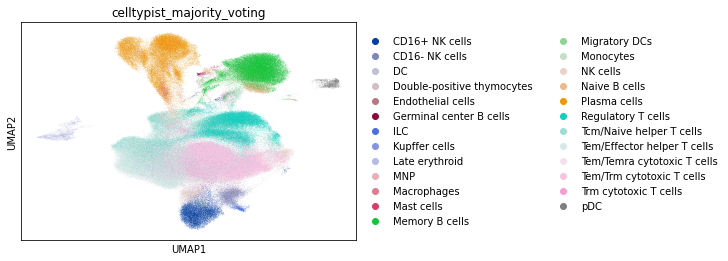

In [105]:
sc.pl.umap(adata_lymphoid, color='celltypist_majority_voting')

In [46]:
chan_cell_type_coarse_df = sc.get.obs_df(adata[adata.obs['dataset'] == 'chan'],keys=['med_cell_type_chan', 'coarse_cell_type_chan'])
chan_cell_type_coarse_df = pd.crosstab(chan_cell_type_coarse_df['med_cell_type_chan'], chan_cell_type_coarse_df['coarse_cell_type_chan']).T

In [47]:
chan_cell_type_coarse_df

med_cell_type_chan,B cell,DC,Endothelial,Epithelial Stroma,Erythrocyte,Fibroblast,Macrophage,Mast,NSCLC,Neutrophil,Plasma cell,SCLC,T cell
coarse_cell_type_chan,,,,,,,,,,,,,
Epithelial,0,0,0,2986,0,0,0,0,993,0,0,364,0
Lymphoid,4629,0,0,0,0,0,0,0,0,0,210,0,23369
Mesenchymal,0,0,2256,0,0,3713,0,0,0,0,0,0,0
Myeloid,0,1619,0,0,38,0,3207,924,0,191,0,0,0


In [42]:
chan_cell_type_df = sc.get.obs_df(adata[adata.obs['dataset'] == 'chan'],keys=['med_cell_type_chan', 'fine_cell_type_chan'])
chan_cell_type_df = pd.crosstab(chan_cell_type_df['med_cell_type_chan'], chan_cell_type_df['fine_cell_type_chan']).T

In [43]:
chan_cell_type_df

med_cell_type_chan,B cell,DC,Endothelial,Epithelial Stroma,Erythrocyte,Fibroblast,Macrophage,Mast,NSCLC,Neutrophil,Plasma cell,SCLC,T cell
fine_cell_type_chan,,,,,,,,,,,,,
AE1,0,0,0,472,0,0,0,0,0,0,0,0,0
AEP,0,0,0,391,0,0,0,0,0,0,0,0,0
B cell,4629,0,0,0,0,0,0,0,0,0,0,0,0
Basal,0,0,0,421,0,0,0,0,0,0,0,0,0
Ciliated,0,0,0,291,0,0,0,0,0,0,0,0,0
Club,0,0,0,74,0,0,0,0,0,0,0,0,0
DC,0,1619,0,0,0,0,0,0,0,0,0,0,0
Endothelial,0,0,2256,0,0,0,0,0,0,0,0,0,0
Erythrocyte,0,0,0,0,38,0,0,0,0,0,0,0,0


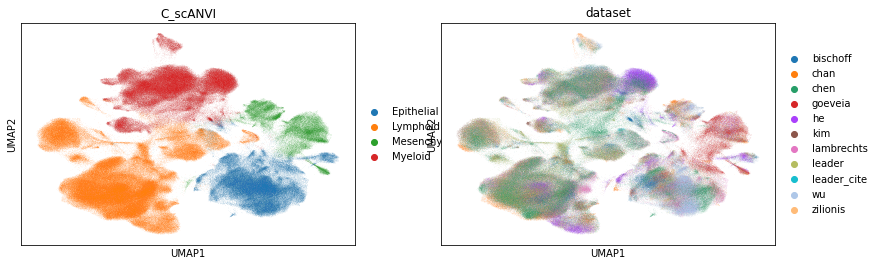

In [41]:
sc.pl.umap(adata, color=['C_scANVI', 'dataset'], save='predication_scanvi.pdf')

In [42]:
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
pro_adata_raw = sc.AnnData(adata.obsm["protein_expression"].copy(), obs=adata.obs)
pro_adata_raw.X = adata.obsm["protein_expression"]
pro_adata_raw.var["protein_names"] = parsed_protein_names

<ipython-input-42-d5f7b8d2e500>:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  pro_adata_raw = sc.AnnData(adata.obsm["protein_expression"].copy(), obs=adata.obs)
/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


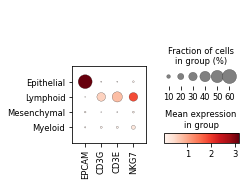

In [48]:
sc.pl.dotplot(adata, ['EPCAM', 'CD3G', 'CD3E', 'NKG7'], groupby='C_scANVI')

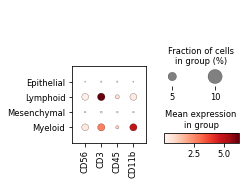

In [50]:
sc.pl.dotplot(pro_adata_raw, ['CD56','CD3', 'CD45', 'CD11b'], groupby='C_scANVI')

In [54]:
kim_prediction = sc.get.obs_df(adata,keys=['cell_type_kim', 'C_scANVI'])
kim_prediction = pd.crosstab(kim_prediction['cell_type_kim'], kim_prediction['C_scANVI']).T

In [55]:
kim_prediction

cell_type_kim,B lymphocytes,Endothelial cells,Epithelial cells,Fibroblasts,MAST cells,Myeloid cells,NK cells,T lymphocytes,Unknown
C_scANVI,,,,,,,,,
Epithelial,6,0,6959,1,0,2,1,6,144240
Lymphoid,5289,3,7,9,6,177,1003,18563,323348
Mesenchymal,1,647,7,1691,1,1,0,2,51769
Myeloid,6,1,27,13,1801,8564,0,14,177277


In [119]:
(dataset_prediction/dataset_prediction.sum())

dataset,bischoff,chan,goeveia,he,kim,lambrechts,leader,leader_cite,wu,zilionis
C_scANVI,,,,,,,,,,
Epithelial,0.230328,0.097306,0.290609,0.119702,0.155865,0.190318,0.051929,0.042544,0.661230,0.106270
Lymphoid,0.447895,0.633407,0.091915,0.312597,0.559677,0.575627,0.665197,0.634826,0.084321,0.541288
Mesenchymal,0.026069,0.135194,0.514142,0.063232,0.052357,0.045354,0.015361,0.016649,0.067799,0.035186
Myeloid,0.295709,0.134093,0.103335,0.504468,0.232101,0.188702,0.267513,0.305981,0.186650,0.317256


### Lymphoid only

In [47]:
adata_lymphoid = adata[adata.obs['level1_cell_type'] == 'Lymphoid'].copy()

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [46]:
#scvi.model.SCVI.setup_anndata(adata_lymphoid, batch_key="batch", labels_key='celltypist_prediction')
scvi.model.SCVI.setup_anndata(adata_lymphoid, batch_key="batch", labels_key='level2_cell_type')

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/_utils.py:156: UserWarning: Category 133 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [47]:
vae = scvi.model.SCVI(adata_lymphoid, n_layers=2, n_latent=30, gene_likelihood="nb")

In [48]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 23/23: 100%|██████████| 23/23 [11:22<00:00, 29.68s/it, loss=2.54e+03, v_num=1]


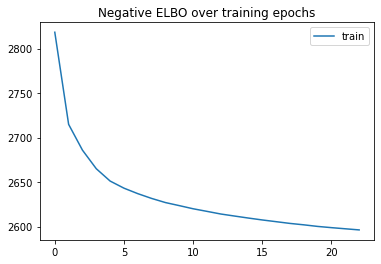

In [204]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [49]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_lymphoid,
    unlabeled_category="Unknown",
)

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/_utils.py:156: UserWarning: Category 133 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [50]:
lvae.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [28:28<00:00, 68.35s/it, loss=2.61e+03, v_num=1]


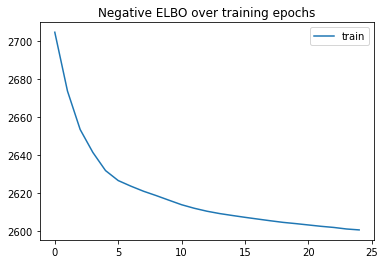

In [207]:
plt.plot(lvae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [65]:
adata_lymphoid.obsm["X_scVI"] = vae.get_latent_representation(adata_lymphoid)

In [52]:
adata_lymphoid.obsm["X_scANVI"] = lvae.get_latent_representation(adata_lymphoid)

In [66]:
sc.pp.neighbors(adata_lymphoid, use_rep="X_scVI")
sc.tl.umap(adata_lymphoid)

In [42]:
adata_lymphoid.obsm["X_scANVI"] = lvae.get_latent_representation(adata_lymphoid)

#### scANVI predication

In [213]:
adata_lymphoid.obs["C_scANVI"] = lvae.predict(adata_lymphoid)

In [43]:
sc.pp.neighbors(adata_lymphoid, use_rep="X_scANVI")
sc.tl.umap(adata_lymphoid)

In [215]:
sc.tl.leiden(adata_lymphoid, resolution=1.5)

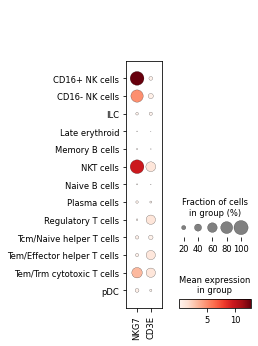

In [70]:
sc.pl.dotplot(adata_lymphoid, ['NKG7', 'CD3E'], groupby='level2_cell_type', save='lymphoid_nkg7_cd3e.pdf')

#### Celltypist predication

In [31]:
import celltypist

In [43]:
adata_myeloid.obs_names_make_unique()

In [45]:
adata_celltypist = adata_myeloid.copy()

In [46]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [47]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 185542 cells and 12675 genes
🔗 Matching reference genes in the model
🧬 3771 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [48]:
adata_myeloid.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_myeloid.obs.index]#.to_numpy()
adata_myeloid.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_myeloid.obs.index]#.to_numpy()

In [51]:
[x for x in adata_myeloid.obs['celltypist_prediction'] if 'neutrop' in x.lower()]

['Neutrophil-myeloid progenitor']

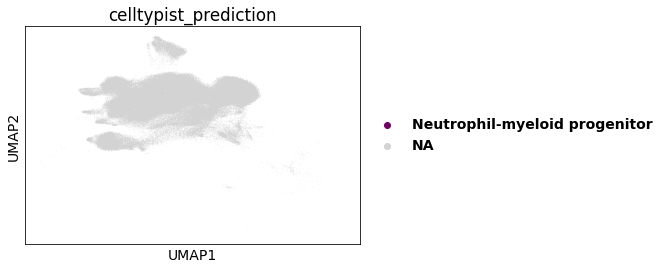

In [52]:
sc.pl.umap(adata_myeloid, color='celltypist_prediction', groups='Neutrophil-myeloid progenitor')

#### AUCell scores

In [17]:
import pickle

In [18]:
hta_mtx = pickle.load(open("hta_marker_gene.pkl", "rb" ))

In [19]:
hta_mtx = hta_mtx.loc[[x for x in hta_mtx.index if x in adata_lymphoid.var.index]]

In [20]:
marker_gene_mat = pd.read_csv('FL_celltype.csv', index_col=0)

In [21]:
marker_gene_mat = marker_gene_mat.loc[[x for x in marker_gene_mat.index if x in adata_lymphoid.var.index]]

In [22]:
t_cell_sig = ['IL7R', 'CCR7', 'CD8A', 'CD3E', 'CD8B']

In [23]:
nk_cell_sig = list(marker_gene_mat.index[marker_gene_mat['NK'] == 1])

In [24]:
nk_cell_sig = ['NKG7', 'KLRC1', 'KLRC2', 'KLRD1', 'NCR1']

In [262]:
#nk_cell_sig = ['GNLY', 'XCL2', 'NKG7', 'CST3', 'SPINK2', 'CDC20', 'HBG2', 'ADGRG1', 'IGFBP4', 'TTLL10']

In [25]:
signature_genes = [nk_cell_sig, t_cell_sig]
signature_names = ['NK', 'T cells']

In [26]:
gene_sigs = [GeneSignature(name,genes) for (name,genes) in zip(signature_names, signature_genes)]

In [27]:
exp_df = adata_lymphoid.to_df()#pd.DataFrame(adata.X.todense(), columns=adata.var.index, index=adata.obs.index)

In [ ]:
#sc.pl.dotplot(adata_lymphoid, nk_cell_sig+t_cell_sig, groupby='leiden')

In [81]:
auc_mtx = aucell(exp_df[nk_cell_sig+t_cell_sig], gene_sigs, num_workers=4)

In [ ]:
adata_lymphoid.obs[[x + '_auc' for x in auc_mtx.columns]] = auc_mtx.to_numpy()

In [39]:
#sc.pl.dotplot(adata_lymphoid, [x + '_auc' for x in auc_mtx.columns], groupby='leiden', save='aucell_score_leiden.pdf')

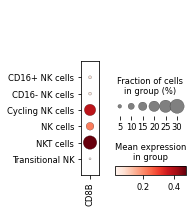

In [250]:
sc.pl.dotplot(adata_lymphoid[[x in ['CD16+ NK cells', 'CD16- NK cells', 'Cycling NK cells', 'NK cells',
       'NKT cells', 'Transitional NK'] for x in adata_lymphoid.obs['celltypist_prediction']]], 'CD8B', groupby='celltypist_prediction')

In [38]:
#sc.pl.dotplot(adata_lymphoid, 'CD8B', groupby='celltypist_majority_voting', save='CD8B.png')

### CITE-seq

In [48]:
pro_adata_lymphoid = sc.AnnData(adata_lymphoid.obsm["protein_expression"].copy(), obs=adata_lymphoid.obs)
pro_adata_lymphoid_non_zero = pro_adata_lymphoid[np.sum(pro_adata_lymphoid.to_df(), axis=1) != 0].copy()

<ipython-input-48-5468d082aede>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  pro_adata_lymphoid = sc.AnnData(adata_lymphoid.obsm["protein_expression"].copy(), obs=adata_lymphoid.obs)


In [50]:
pro_adata_lymphoid_non_zero = pro_adata_lymphoid[np.sum(pro_adata_lymphoid.to_df(), axis=1) != 0].copy()

In [60]:
pro_adata_lymphoid_non_zero.obs['celltypist_majority_voting'] = [x if not x == 'NK cells' else 'NKT cells' for x in pro_adata_lymphoid_non_zero.obs['celltypist_majority_voting']]

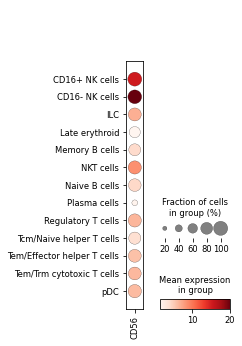

In [51]:
sc.pl.dotplot(pro_adata_lymphoid_non_zero, ['CD56'], groupby='level2_cell_type')#, save='ADT_CD56.pdf')